# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration ##

In [16]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [90]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [94]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [17]:
def listToString(s):  
    
    '''
    converts list to string
    
    INPUT
    list
    
    OUTPUT
    string variable
    
    '''
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 


def clean_portfolio(df):
    
    '''
    cleans portfolio data to usable format
    
    INPUT
    dataframe
    
    OUTPUT
    cleaned data frame with channels column one hot encoded
    
    '''
    n=0;
    for i in portfolio.channels:
        portfolio.channels[n]=listToString(i)
        n=n+1;
    
    cleaned = portfolio.set_index('id').channels.str.split(expand=True).stack()

    cleaned_channels=pd.get_dummies(cleaned, prefix='channel').groupby(level=0).sum()

    cleaned_portfolio=pd.merge(portfolio, cleaned_channels, how ='inner', on ='id')
    #cleaned_offer=pd.get_dummies(cleaned_portfolio['offer_type'])
    #cleaned_portfolio=pd.concat([cleaned_portfolio, cleaned_offer], axis=1, sort=False)
    cleaned_portfolio=pd.concat([cleaned_portfolio,], axis=1, sort=False)
    cleaned_portfolio.drop(['channels'], inplace=True, axis=1)
  
    return cleaned_portfolio

clean_portfolio=clean_portfolio(portfolio)
clean_portfolio

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,difficulty,duration,id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [18]:
def Offers(id): 
    
    '''
    Categorizes an ID into its corresponding offer 
    
    INPUT
    offer ID
    
    OUTPUT
    an offer string variable
    
    '''
    
    offer = ''
    
    if id=='ae264e3637204a6fb9bb56bc8210ddfd':
        offer = '10_7_bogo_10'
    
    elif id == '4d5c57ea9a6940dd891ad53e9dbe8da0':
        offer = '10_5_bogo_10'
        
    elif id == '3f207df678b143eea3cee63160fa8bed':
        offer = '0_4_informational_0'
    
    elif id == '9b98b8c7a33c4b65b9aebfe6a799e6d9':
        offer = '5_7_bogo_5'
    
    elif id == '0b1e1539f2cc45b7b9fa7c272da2e1d7':
        offer = '20_10_discount_5'
    
    elif id == '2298d6c36e964ae4a3e7e9706d1fb8c2':
        offer = '7_7_discount_3'
        
    elif id == 'fafdcd668e3743c1bb461111dcafc2a4':
        offer = '10_10_discount_2'
        
    elif id == '5a8bc65990b245e5a138643cd4eb9837':
        offer = '0_3_informational_0'
        
    elif id == 'f19421c1d4aa40978ebb69ca19b0e20d':
        offer = '5_5_bogo_5'
        
    elif id == '2906b810c7d4411798c6938adc9daaa5':
        offer = '10_7_discount_2' 

    return offer 

#apply the offers function
clean_portfolio['offer'] = clean_portfolio['id'].apply(Offers)
clean_portfolio

,difficulty,duration,id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,10_7_bogo_10
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,10_5_bogo_10
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0_4_informational_0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,20_10_discount_5
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,7_7_discount_3
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,10_10_discount_2
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0_3_informational_0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,5_5_bogo_5
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,10_7_discount_2


In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
from datetime import datetime

def clean_profile(df):
    
    
    '''
    cleans profile data into a usable fromat 
    
    INPUT
    datafarme
    
    OUTPUT
    cleaned dataframe with membership days in a seperate column and NAN rows removed
    
    '''
    
    cleaned_profile=profile.dropna(how='all')
    cleaned_profile.drop(cleaned_profile[cleaned_profile['age'] == 118].index, inplace = True) 
    cleaned_profile=cleaned_profile.reset_index(drop=True)
    
    cleaned_profile['days']= datetime.now()-pd.to_datetime(cleaned_profile['became_member_on'], format='%Y%m%d')
    n=0;
    for i in cleaned_profile.days:
        cleaned_profile.days[n]=cleaned_profile.days[n].days
        n=n+1;
        
    return cleaned_profile

clean_profile=clean_profile(profile)
clean_profile.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,age,became_member_on,gender,id,income,days
0,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1291
1,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1358
2,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1006
3,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,1082
4,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1172


In [7]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [8]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [64]:
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [8]:
#extract offer id and amount in columns
def clean_transcript(transcript):
    '''
    cleans transcript dataframe
    
    INPUT:
    the transcript dataframe to be cleaned
    
    OUTPUT:
    the cleaned dataframe with offer_id and amount in seperate columns
    
    '''
    clean_transcript = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) or ('amount' in x) else False)]
    clean_transcript['offer_id'] = clean_transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else (x['offer_id'] if ('offer_id' in x) else None))
    clean_transcript['amount'] = clean_transcript['value'].apply(lambda x: x['amount'] if ('amount' in x) else 0)
    clean_transcript=clean_transcript.drop(columns=['value'])
    
    return clean_transcript

clean_transcript = clean_transcript(transcript)
clean_transcript

,event,person,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.00
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.00
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.00
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.00
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00


In [9]:
clean_transcript[clean_transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0.00
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,0.00
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,None,19.67
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,None,29.72
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,None,23.93


## Data Visualization ##

### Univariate plots to better understand each attribute

### Demographic segmentation variables
1. Age
2. Gender
3. Income
4. Days of Membership

#### Profile

#### Age Visualization

Text(0,0.5,'Count')

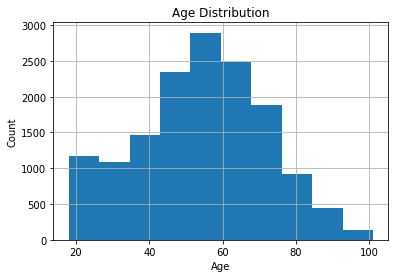

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

clean_profile.age.hist()
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

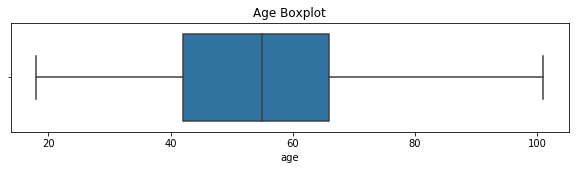

In [6]:


plt.figure(figsize=(10, 2))
sns.boxplot(clean_profile['age'])
plt.title('Age Boxplot')
plt.show();

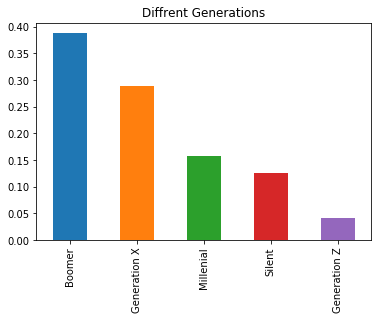

In [28]:
def Generation(age): 
    
    '''
    Categorizes an age into its corresponding generation.
    
    INPUT
    age value
    
    OUTPUT
    a generation string variable
    
    '''
    
    age = int(age)
    
    if age in range(7,23):
        generation = 'Generation Z'
    
    elif age in range(23,39):
        generation = 'Millenial'
    
    elif age in range(39,55):
        generation = 'Generation X'
    
    elif age in range(55,74):
        generation = 'Boomer'
        
    elif age in range(74,92):
        generation = 'Silent'
    else: 
        generation = 'Other'

    return generation 

#rows with null age values are removed from df as they are not needed
clean_profile = clean_profile.dropna(subset=['age'], how='any')

#apply the Generatoin function
clean_profile['Generation'] = clean_profile['age'].apply(Generation)

#drop rows with a generation of (other) as it is not useful in the comparsion
clean_profile.drop(clean_profile.index[clean_profile['Generation'] == 'Other'], inplace = True)

(clean_profile['Generation'].value_counts()/clean_profile.shape[0]).plot(kind='bar');
plt.title('Diffrent Generations');

#### Income Visualization

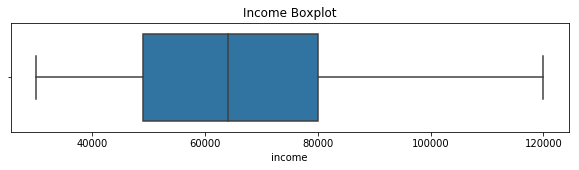

In [19]:
plt.figure(figsize=(10, 2))
sns.boxplot(clean_profile['income'])
plt.title('Income Boxplot')
plt.show();

#### Days of Membership Visualization

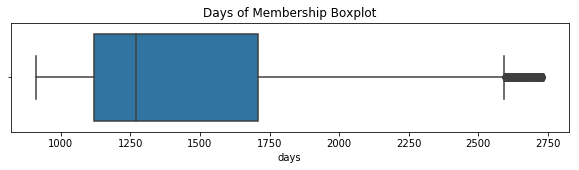

In [23]:
plt.figure(figsize=(10, 2))
clean_profile['days'] = clean_profile['days'].astype(float)
sns.boxplot(clean_profile['days'])
plt.title('Days of Membership Boxplot')
plt.show();

#### Gender Visualization

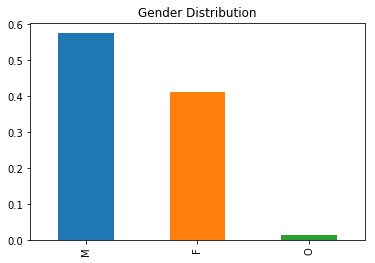

In [29]:
(clean_profile['gender'].value_counts()/clean_profile.shape[0]).plot(kind='bar');
plt.title('Gender Distribution');

#### Transcript

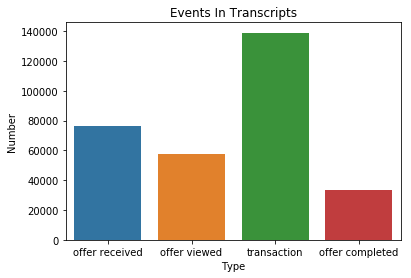

In [73]:
#count of events in transcript dataframe
sns.countplot(clean_transcript['event'])
plt.title('Events In Transcripts')
plt.ylabel('Number')
plt.xlabel('Type')
plt.show();

### Multivariate Plots ###

In [19]:
#merge transcript and portfolio data for plotting
transcript_portfolio = clean_transcript.merge(clean_portfolio, left_on='offer_id', right_on='id')
transcript_portfolio

,event,person,time,offer_id,amount,difficulty,duration,id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
5,offer received,a3b9b4bf115e4564933ea2e4bc936843,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
6,offer received,32fbf97e89274e8a935903f2ad095e1f,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
7,offer received,52f0bd64403f4958ab8fe9a6947c13c3,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
8,offer received,d41fa9b8c2e24a1d94caa890c53bbcf6,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
9,offer received,c099206f76b1414db7552f163520053c,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5


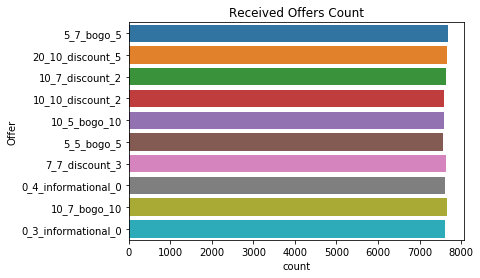

In [29]:
#received offers count
received_offer_count = transcript_portfolio[transcript_portfolio['event'] == 'offer received']
sns.countplot(y=received_offer_count['offer'])

plt.title('Received Offers Count')
plt.ylabel('Offer')
plt.show();

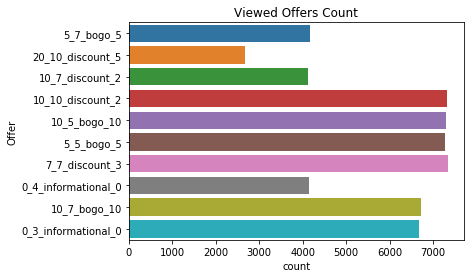

In [107]:
#viewed offers count
viewed_offer_count = transcript_portfolio[transcript_portfolio['event'] == 'offer viewed']
sns.countplot(y=viewed_offer_count['offer'])

plt.title('Viewed Offers Count')
plt.ylabel('Offer')
plt.show();

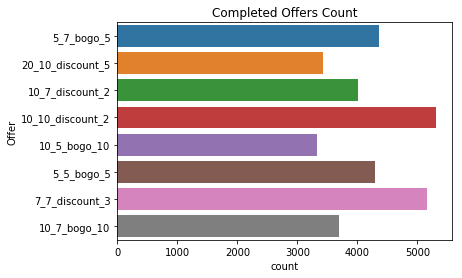

In [48]:
#completed offers count
completed_offer_count = transcript_portfolio[transcript_portfolio['event'] == 'offer completed']
sns.countplot(y=completed_offer_count['offer'])

plt.title('Completed Offers Count')
plt.ylabel('Offer')
plt.show();

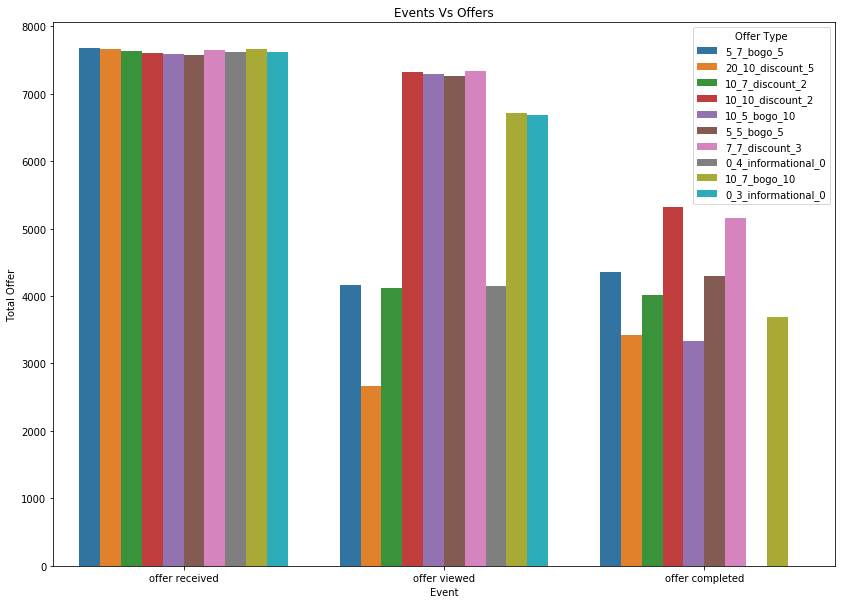

In [24]:

plt.figure(figsize=(14, 10))
sns.countplot(x="event", hue="offer", data=transcript_portfolio)
plt.title('Events Vs Offers')
plt.ylabel('Total Offer')
plt.xlabel('Event')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

In [29]:
#merge transcript and portfolio and profile data for plotting
transcript_profile=clean_transcript.merge(clean_profile, left_on='person', right_on='id')
transcript_profile_portfolio=transcript_profile.merge(clean_portfolio, left_on='offer_id', right_on='id')
transcript_profile_portfolio

,event,person,time,offer_id,amount,age,became_member_on,gender,id_x,income,...,difficulty,duration,id_y,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
3,offer received,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
5,offer completed,e2127556f4f64592b11af22de27a7932,522,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
6,offer received,389bc3fa690240e798340f5a15918d5c,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
7,offer viewed,389bc3fa690240e798340f5a15918d5c,192,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
8,offer received,389bc3fa690240e798340f5a15918d5c,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
9,offer viewed,389bc3fa690240e798340f5a15918d5c,438,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5


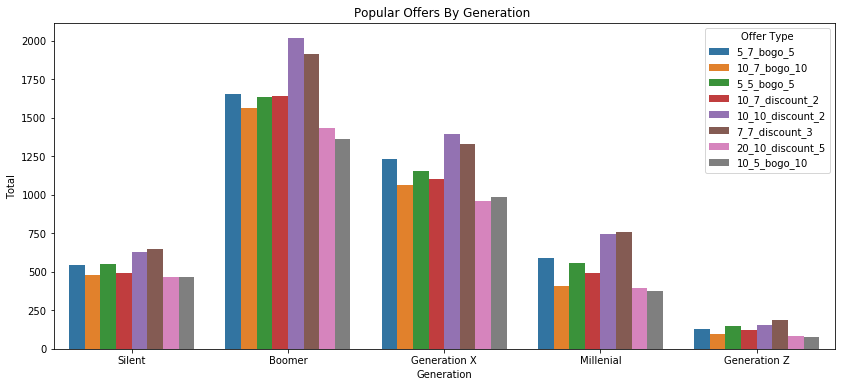

In [30]:
#most popular offers by generation
completed_offer = transcript_profile_portfolio[transcript_profile_portfolio['event'] == 'offer completed']
plt.figure(figsize=(14, 6))
sns.countplot(x="Generation", hue="offer", data=completed_offer)
plt.title('Popular Offers By Generation ')
plt.ylabel('Total')
plt.xlabel('Generation')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

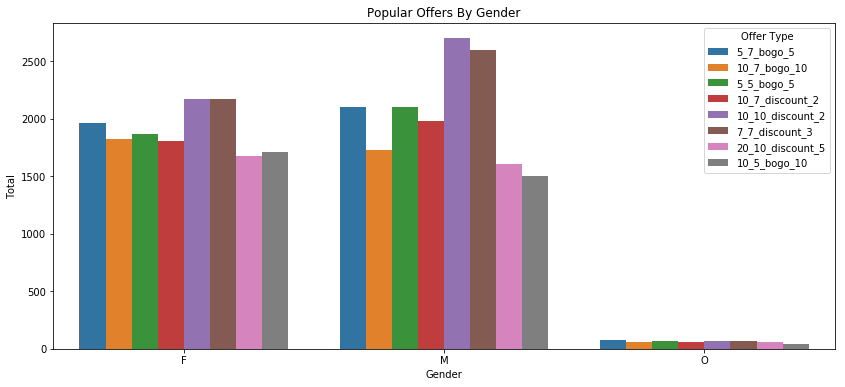

In [55]:
#most popular offers by gender
plt.figure(figsize=(14, 6))
sns.countplot(x="gender", hue="offer", data=completed_offer)
plt.title('Popular Offers By Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

## Data Preprocessing ##

featuers: 
1. event 
2. days of membership
3. age
4. gender
5. income
6. amount paid 
7. difficulty


target:
offer (bogo, discount, info)

In [51]:
transcript_profile_portfolio.head()

,event,person,time,offer_id,amount,age,became_member_on,gender,id_x,income,...,difficulty,duration,id_y,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
3,offer received,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,5_7_bogo_5


In [47]:
df = transcript_profile_portfolio[['event', 'amount', 'offer_type','days','age','gender','income','difficulty']]
df.head()

,event,amount,offer_type,days,age,gender,income,difficulty
0,offer received,0.0,bogo,1358,75,F,100000.0,5
1,offer viewed,0.0,bogo,1358,75,F,100000.0,5
2,offer completed,0.0,bogo,1358,75,F,100000.0,5
3,offer received,0.0,bogo,1006,68,M,70000.0,5
4,offer viewed,0.0,bogo,1006,68,M,70000.0,5


In [48]:
cleanup = {"event":     {"offer received": 1, "offer viewed": 2, "offer completed": 3, "transaction": 4},
           "offer_type": {"bogo": 1, "discount": 2, "informational": 3},
           "gender": {"F": 1, "M": 2, "O": 3}}
df = df.replace(cleanup)
df.head()

,event,amount,offer_type,days,age,gender,income,difficulty
0,1,0.0,1,1358,75,1,100000.0,5
1,2,0.0,1,1358,75,1,100000.0,5
2,3,0.0,1,1358,75,1,100000.0,5
3,1,0.0,1,1006,68,2,70000.0,5
4,2,0.0,1,1006,68,2,70000.0,5


In [49]:
target = df['offer_type']
features = df.drop(['offer_type'], axis = 1)

In [16]:
target.head()

0    1
1    1
2    1
3    1
4    1
Name: offer_type, dtype: int64

In [17]:
features.head()

,event,amount,days,age,gender,income
0,1,0.0,1357,75,1,100000.0
1,2,0.0,1357,75,1,100000.0
2,3,0.0,1357,75,1,100000.0
3,1,0.0,1005,68,2,70000.0
4,2,0.0,1005,68,2,70000.0


### Normalize ###

In [50]:
from sklearn import preprocessing

features[['amount','age','days', 'income']]=preprocessing.normalize(features[['amount','age','days', 'income']])
features.head()

,event,amount,days,age,gender,income,difficulty
0,1,0.0,0.013579,0.000750,1,0.999908,5
1,2,0.0,0.013579,0.000750,1,0.999908,5
2,3,0.0,0.013579,0.000750,1,0.999908,5
3,1,0.0,0.014370,0.000971,2,0.999896,5
4,2,0.0,0.014370,0.000971,2,0.999896,5


### Split train & test sets ###

In [52]:
# Split-out validation dataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

X_train, X_validation, Y_train, Y_validation = train_test_split(features, target, test_size=0.20, random_state=1)
#scale data
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_validation = scaling.transform(X_validation)

## Modeling ##

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

### Estimation Accuracy ###

In [58]:
#https://machinelearningmastery.com/machine-learning-in-python-step-by-step/

ML_models = [('Logistic Regression', LogisticRegression(solver='liblinear', multi_class='ovr')), 
             ('K Nearest Neighbors', KNeighborsClassifier()),
             ('Classification Tree', DecisionTreeClassifier()),
             ('Gaussian Naive Bayes', GaussianNB())]

# evaluate each model in turn
for name, model in ML_models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

Logistic Regression: 0.661780 (0.004963)
K Nearest Neighbors: 0.787471 (0.004338)
Classification Tree: 0.787726 (0.004020)
Gaussian Naive Bayes: 0.663965 (0.001306)


### Prediction Accuracy ###

In [61]:
# Make predictions on validation dataset
models_pred =[('Logistic Regression', LogisticRegression(solver='liblinear', multi_class='ovr')), 
              ('K Nearest Neighbors', KNeighborsClassifier()),
              ('Classification Tree', DecisionTreeClassifier()),
              ('Gaussian Naive Bayes', GaussianNB())]

for name, model in models_pred:
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    print('%s: %f' % (name, accuracy_score(Y_validation, predictions)))

Logistic Regression: 0.658571
K Nearest Neighbors: 0.783163
Classification Tree: 0.784150
Gaussian Naive Bayes: 0.664864


## Refinement &  Model Evaluation and Validation ## 

### KNN ###

In [62]:
#https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/

err = []
# Calculating error for K values between 1 and 40
for i in range(1, 40):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, Y_train)
    pred = model.predict(X_validation)
    err.append(np.mean(pred != Y_validation))

Text(0,0.5,'Mean Error')

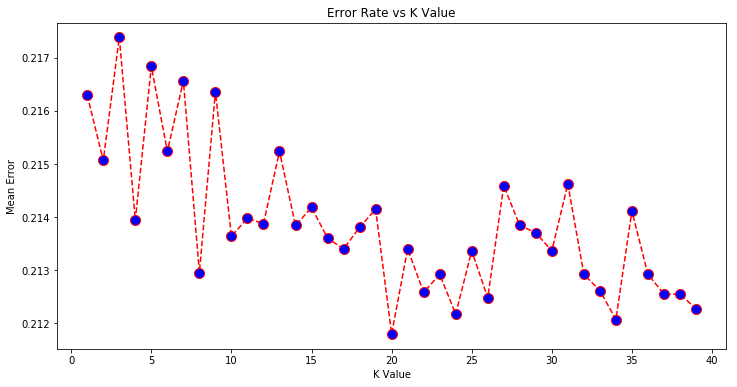

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), err, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate vs K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [70]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Evaluate predictions
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X_train, Y_train)
pred = model.predict(X_validation)

print(accuracy_score(Y_validation, pred))
print(confusion_matrix(Y_validation, pred))
print(classification_report(Y_validation, pred))

0.788197278912
[[10081  2568     0]
 [ 3659  8578     0]
 [    0     0  4514]]
             precision    recall  f1-score   support

          1       0.73      0.80      0.76     12649
          2       0.77      0.70      0.73     12237
          3       1.00      1.00      1.00      4514

avg / total       0.79      0.79      0.79     29400



### Decision Tree Classifier ###

Text(0,0.5,'Mean Error')

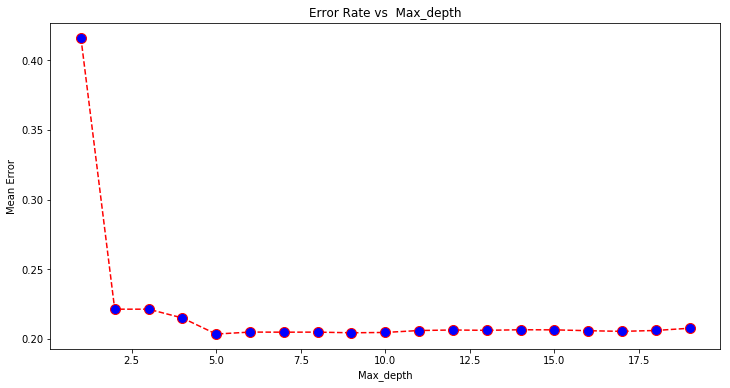

In [91]:
#https://www.datacamp.com/community/tutorials/decision-tree-classification-python
err = []
# Calculating error for K values between 1 and 40
for i in range(1, 20):
    model = DecisionTreeClassifier(criterion="entropy", splitter='best',max_depth=i)
    model.fit(X_train, Y_train)
    pred = model.predict(X_validation)
    err.append(np.mean(pred != Y_validation))
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 20), err, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate vs  Max_depth')
plt.xlabel('Max_depth')
plt.ylabel('Mean Error')

In [92]:
print(accuracy_score(Y_validation, pred))
print(confusion_matrix(Y_validation, pred))
print(classification_report(Y_validation, pred))

0.792380952381
[[11293  1356     0]
 [ 4748  7489     0]
 [    0     0  4514]]
             precision    recall  f1-score   support

          1       0.70      0.89      0.79     12649
          2       0.85      0.61      0.71     12237
          3       1.00      1.00      1.00      4514

avg / total       0.81      0.79      0.79     29400



## Conclusion ##

Simulated Starbucks' rewards app data was used to find the most suitable offers for customers based on demographic segmentation. Visualizations were used to find the following insights: 
1. The income range of the rewards app users falls between 50K and 80K per year.
2. 10_10_discount_2, 10_5_bogo_10, 5_5_bogo_5, and 7_7_discount_3 are the most viewed offers
3. 20_10_discount_5 is the least viewed offer which may be due to its high spend requirement
4. 10_10_discount_2, and 7_7_discount_3 are the most completed offers in general
5. Boomers comprise the majority of starbucks' customers with perferance for 10_10 discount_2 and 7_7_discount_3. These two offers are also popular in all generations
6. females completed more 10_7_bogo_10 offers even though they are less in number than the males.

Moreover, four supervised ML models were used to classify the best offers based on demographic features and it was found that KNN and CART producr the best results with ~80% prediction accuracy. 
This projects was intresting because it posed a real life problem and it included formulating data centric solutions for the starbucks problem. Improvements can be made to the above solution by trying other ML models to try and classify the offer such as support vector machines and linear discriminant analysis.